In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
import sys

try:
    from fluidity_tools import stat_parser as stat
except ImportError:
    # try again by adding the path "../python" relative to testharness' own location to sys.path
    head, tail = os.path.split(sys.argv[0])
    # python_path = os.path.abspath(os.path.join(head, '..', 'python'))
    sys.path.append('/home/gn/Code/fetch2012/fluidity/python')
    from fluidity_tools import stat_parser as stat


import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib2tikz import save as tikz_save

# Make background white
plt.style.use('default')

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
matplotlib.rc('font', **{'family': 'sans-serif',
                         'sans-serif': ['DejaVu Sans'], 'size': 10})

# Set the font used for MathJax - more on this later
matplotlib.rc('mathtext', **{'default': 'regular'})


class ExtractLB:
    def __init__(self):
        self.WALL_T = {}
        self.LB_T = {}
        self.CDOFS = {}

    def get_run_stats(self, dir, log_name, cores):
        """
            Extracts the Load balancer, solver and CDOFs
            out of the stat files, crawling directories following the name
            coreXXX/rad_radiant_noio.e
        """
        # Store the directory before you start
        root_dir = os.getcwd()
        STAT_F = f'{log_name}.Neutron.output_quantities.stat'
        # Use the Fluidity module to load the stat files into arrays
        for cpu in cores:
            os.chdir(f'{dir}/core{cpu}')
            self.LB_T[cpu] = stat(STAT_F)['RadiantLoadBalanceTime']['Value']
            self.WALL_T[cpu] = stat(STAT_F)['ElapsedWallTime']['Value']
            self.CDOFS[cpu] = stat(STAT_F)['ContinuousDOF_per_group']['Value']

        # Change back to the initial directory
        os.chdir(root_dir)

        return self.WALL_T, self.LB_T, self.CDOFS

    def get_partition_stats(self, dir, log_name, max_adapt, num_cores):
        """
        Get the mean and mode partition sizes for each adapt step
        for a given number of processors.

        len(mean_partition_sizes) : max_adapt
        len(mode_partition_sizes) : max_adapt
        len(nodes): max_adapt * num_cores
        """

        # Store the directory before you start
        root_dir = os.getcwd()
        os.chdir(f'{dir}/core{num_cores}')

        # First load the size of partitions from log files
        # You need to checkout archer_loadbalancer branch
        nodes = []
        for i in range(num_cores):
            nodes.extend(np.loadtxt(f'{log_name}.log_{i}', usecols=(1)))

        mean_partition_sizes = []
        mode_partition_sizes = []
        for adapt in range(max_adapt):
            # Gets the average partition size, which should remain constant
            # unless the elements present in the spatial mesh change
            mean_partition_sizes.append(
                sum(nodes[adapt::max_adapt])/len(nodes[adapt::max_adapt]))

            # Calculates the Mode of the partition sizes
            # TODO: write algorithm for multiple modes of an array
            mode_partition_sizes.append(stats.mode(nodes[adapt::max_adapt])[0])

        # Convert to numpy arrays
        mean_partition_sizes = np.asarray(mean_partition_sizes)
        mode_partition_sizes = np.asarray(mode_partition_sizes)
        nodes = np.asarray(nodes)

        # Return to original directory
        os.chdir(root_dir)

        return mean_partition_sizes, mode_partition_sizes, nodes

    def get_halo_stats(self, dir, log_name, max_adapt, num_cores):
        """
        Get the mean and mode of for halo sizes 
        for a given number of processors at every adapt step

        len(mean_halo_sizes) : max_adapt
        len(mode_halo_sizes) : max_adapt
        len(halos): max_adapt * num_cores
        """

        # Store the directory before you start
        root_dir = os.getcwd()
        os.chdir(f'{dir}/core{num_cores}')

        halos = []
        for i in range(num_cores):
            halos.extend(np.loadtxt(f'{log_name}.log_{i}', usecols=(3)))

        mean_halo_sizes = []
        mode_halo_sizes = []
        for adapt in range(max_adapt):
            # Gets the average partition size, which should remain constant
            # unless the elements present in the spatial mesh change
            mean_halo_sizes.append(
                sum(halos[adapt::max_adapt])/len(halos[adapt::max_adapt]))

            # Calculates the Mode of the partition sizes
            # TODO: write algorithm for multiple modes of an array
            mode_halo_sizes.append(stats.mode(halos[adapt::max_adapt])[0])

        # Convert to numpy array
        mean_halo_sizes = np.asarray(mean_halo_sizes)
        mode_halo_sizes = np.asarray(mode_halo_sizes)
        halos = np.asarray(halos)

        # Return to original directory
        os.chdir(root_dir)

        return mean_halo_sizes, mode_halo_sizes, halos

    def get_node_to_halo_ratio_stats(self, dir, log_name, max_adapt, num_cores):
        __, __, halos = self.get_halo_stats(
            dir, log_name, max_adapt, num_cores)
        __, __, nodes = self.get_partition_stats(
            dir, log_name, max_adapt, num_cores)

        ratio = nodes/halos

        mean_ratio = []
        mode_ratio = []
        for adapt in range(MAX_ADAPT):
            mean_ratio.append(
                sum(ratio[adapt::max_adapt])/len(ratio[adapt::max_adapt]))
            mode_ratio.append(stats.mode(ratio[adapt::max_adapt])[0])

        return mean_ratio, mode_ratio, ratio
    
    # def get_node_to_halo_3d(self, dir, )

    def get_strong_scaling(self, cores):
        """ Pass a list for the number of cores used in the study.
            And assuming you have already loaded the data
            you will generate the strong scaling performance
        """
        return [self.strong_scaling(self.WALL_T[min(cores)][-1], min(cores), self.WALL_T[cpu][-1], cpu) for cpu in cores]

    @staticmethod
    def strong_scaling(t0, c0, tn, cn):
        """
            Takes the time and number of cores for 2 simulations and returns 
        """
        return t0 / (cn/c0 * tn) * 100



/home/gn/anaconda3/lib/python3.7/site-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


In [2]:
CORES = [72, 240, 480, 1080]
NODES = [3, 10, 20, 45]


MAX_ADAPT = 5
f_brunner_name = 'rad_radiant_noio'
f_dogleg_name = 'rad_dogleg_noio'
dir_dogleg = '/home/gn/Code/Archer/tests/mc2019/dogleg'
dir_brunner = '/home/gn/Code/Archer/tests/mc2019/brunner'

# Example of how you save tikz images
# tikz_save('/home/gn/Dropbox/PhD/Posters/ESE_2019/figures/dogleg_speedup.tikz',
#             figureheight='\\figureheight',
#             figurewidth='\\figurewidth')

dogleg = ExtractLB()
wall_t, lb_t, cdof = dogleg.get_run_stats(dir_dogleg, f_dogleg_name, CORES)

brunner = ExtractLB()
wall_t_b, lb_t_b, cdof_b = brunner.get_run_stats(
    dir_brunner, f_brunner_name, CORES)



 # Strong scaling results

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


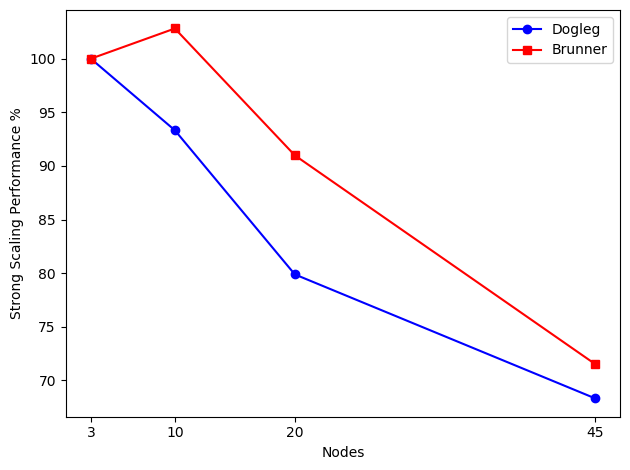

In [3]:
# Strong scaling plot
sc_dogleg = dogleg.get_strong_scaling(CORES)
sc_brunner = brunner.get_strong_scaling(CORES)
# TODO: change the number of processors to number of nodes and hence tick values
fig, ax = plt.subplots()
fig.canvas.set_window_title('Strong scaling dogleg problem')
ax.plot(CORES, sc_dogleg, label='Dogleg', marker='o', color='blue')
ax.plot(CORES, sc_brunner, label='Brunner', marker='s', color='red')
ax.set(xlabel='Nodes', ylabel='Strong Scaling Performance %')
ax.set_xticks(CORES)
ax.set_xticklabels(NODES)
ax.legend()
fig.tight_layout()
fig.savefig('./figures/strong_scaling_perf_wall_time_vs_nodes_adapt_5.png', dpi=300, pad_inches=0)
fig.show()

 # Time spent load balancing

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


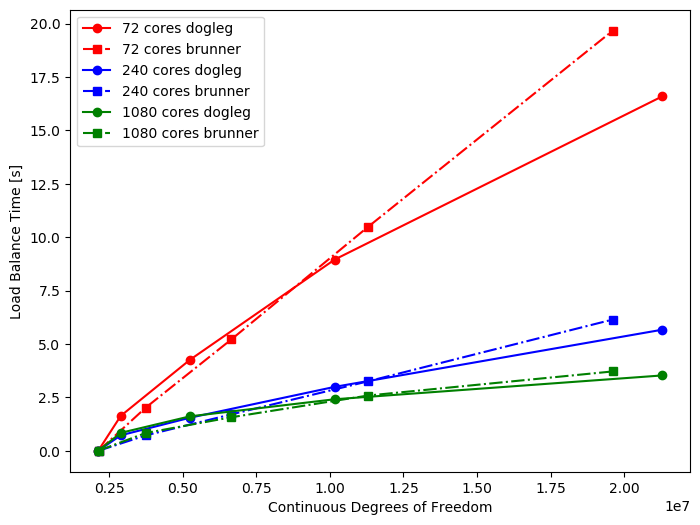

In [4]:
fix, ax = plt.subplots(figsize=(8, 6))
for cpu, c in zip([72, 240, 1080], ['red', 'blue', 'green']):
    ax.plot(cdof[cpu], lb_t[cpu], marker='o',
            label=f'{cpu} cores dogleg', color=c)
    ax.plot(cdof_b[cpu], lb_t_b[cpu], marker='s',
            linestyle='-.', label=f'{cpu} cores brunner', color=c)

ax.set(xlabel='Continuous Degrees of Freedom', ylabel='Load Balance Time [s]')
ax.legend()
fig.tight_layout()
# fig.savefig(fname)
fig.show()

 # Mode Node/Halo plot after adapting

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


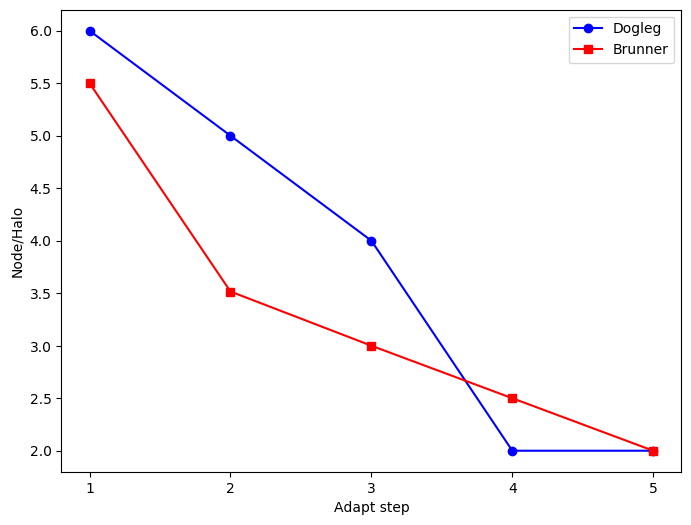

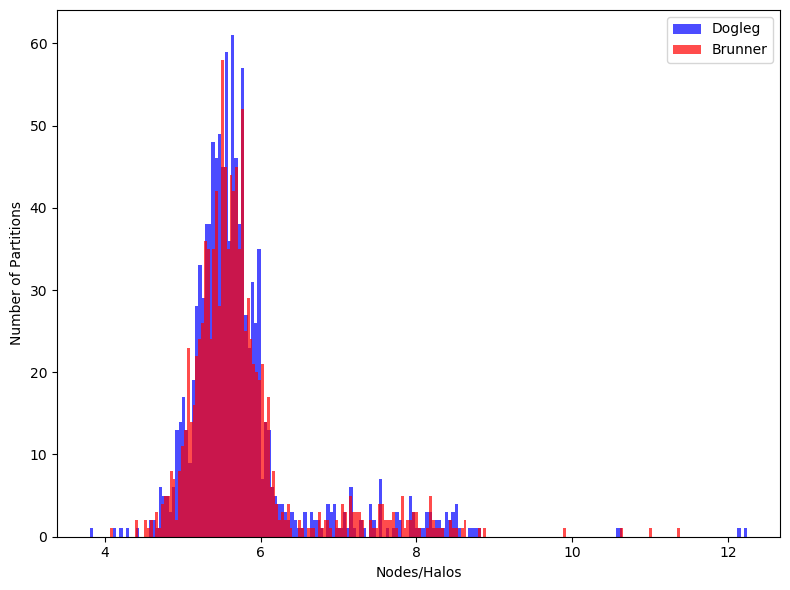

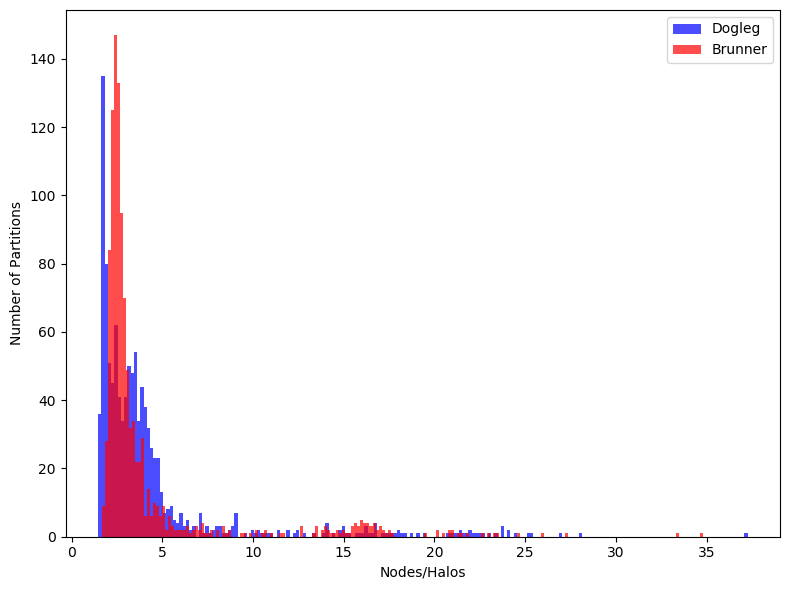

In [5]:
_, ratio_mode_brunner, r_brunner = brunner.get_node_to_halo_ratio_stats(
                                                             dir_brunner, 
                                                             f_brunner_name, 
                                                             MAX_ADAPT, 
                                                             CORES[-1])
_, ratio_mode_dogleg, r_dogleg = dogleg.get_node_to_halo_ratio_stats(dir_dogleg, 
                                                           f_dogleg_name,
                                                           MAX_ADAPT,
                                                           CORES[-1])
# # Mode of Node/Halo ratio distributions vs adapts                                                   
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, MAX_ADAPT+1), ratio_mode_dogleg,
        label='Dogleg', color='blue', marker='o')
ax.plot(range(1, MAX_ADAPT+1), ratio_mode_brunner,
        label='Brunner', color='red', marker='s')
ax.set(xlabel='Adapt step', ylabel='Node/Halo')
ax.set_xticks(range(1, MAX_ADAPT+1))
ax.legend()
fig.show()

# # Initial Node/Halo distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(r_dogleg[0::MAX_ADAPT], bins=200, color='blue', label='Dogleg', alpha=0.7)
ax.hist(r_brunner[0::MAX_ADAPT], bins=200, color='red', label='Brunner', alpha=0.7)
ax.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax.legend()
fig.tight_layout()
fig.show()
# TODO: plot animmation for conference (maybe just use the 240 core case)
# # After 5 adapt steps with load balancing distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(r_dogleg[4::MAX_ADAPT], bins=200, color='blue', label='Dogleg', alpha=0.7)
ax.hist(r_brunner[4::MAX_ADAPT], bins=200, color='red', label='Brunner', alpha=0.7)
ax.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax.legend()
fig.tight_layout()
fig.show()
################################################################################
################################ DOGLEG ########################################
################################################################################

 # DOGLEG
 ## Get the mean and mode of node distribution for partition
###############################################################################

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


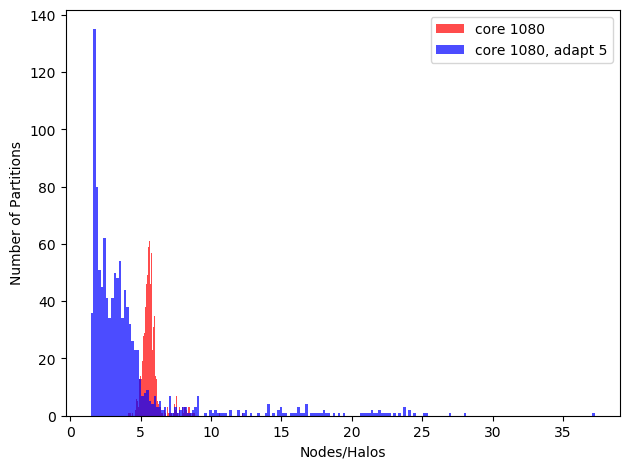

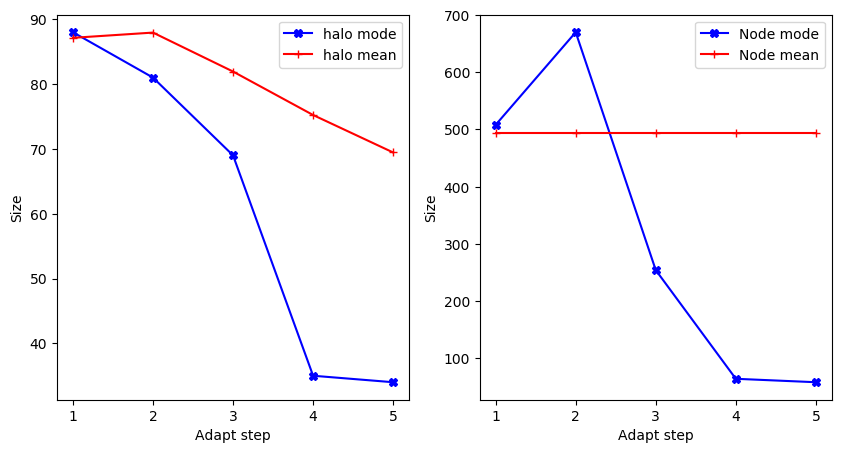

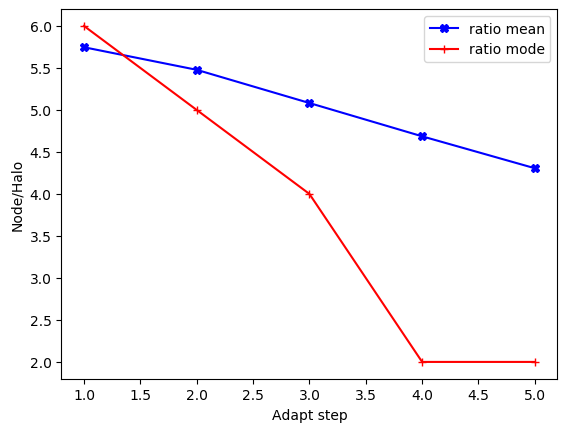

In [6]:
halo_mean, halo_mode, halos = dogleg.get_halo_stats(dir_dogleg,
                                                    f_dogleg_name,
                                                    MAX_ADAPT, CORES[-1])
node_mean, node_mode, nodes = dogleg.get_partition_stats(dir_dogleg,
                                                         f_dogleg_name,
                                                         MAX_ADAPT, CORES[-1])
# Print histogram statistics
fig1, ax1 = plt.subplots()
ax1.hist(nodes[0::MAX_ADAPT]/halos[0::MAX_ADAPT], 200,
         label='core 1080', color='red', alpha=0.7)
ax1.hist(nodes[4::MAX_ADAPT]/halos[4::MAX_ADAPT], 200,
         label='core 1080, adapt 5', color='blue', alpha=0.7)

ax1.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax1.legend()
fig1.tight_layout()
# fig1.savefig(fname)
fig1.show()

# Print halo statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, MAX_ADAPT+1), halo_mode,
         label='halo mode', color='blue', marker='X')
ax1.plot(range(1, MAX_ADAPT+1), halo_mean,
         label='halo mean', color='red', marker='+')
ax1.set(xlabel='Adapt step', ylabel='Size')
ax1.legend()

# Print node statistics
ax2.plot(range(1, MAX_ADAPT+1), node_mode,
         label='Node mode', color='blue', marker='X')
ax2.plot(range(1, MAX_ADAPT+1), node_mean,
         label='Node mean', color='red', marker='+')
ax2.set(xlabel='Adapt step', ylabel='Size')
ax2.legend()
fig.show()

# Calculate the mode of Node/Halo vs Mean
ratio_mean, ratio_mode, __ = dogleg.get_node_to_halo_ratio_stats(
    dir_dogleg, f_dogleg_name, MAX_ADAPT, CORES[-1])
fig, ax = plt.subplots()
ax.plot(range(1, MAX_ADAPT+1), ratio_mean,
        label='ratio mean', color='blue', marker='X')
ax.plot(range(1, MAX_ADAPT+1), ratio_mode,
        label='ratio mode', color='red', marker='+')
ax.set(xlabel='Adapt step', ylabel='Node/Halo')
ax.legend()
fig.show()

################################################################################
############################### BRUNNER ########################################
################################################################################

 # BRUNNER LATTICE PROBLEM

 ## Get the mean and mode of node distribution for partition

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


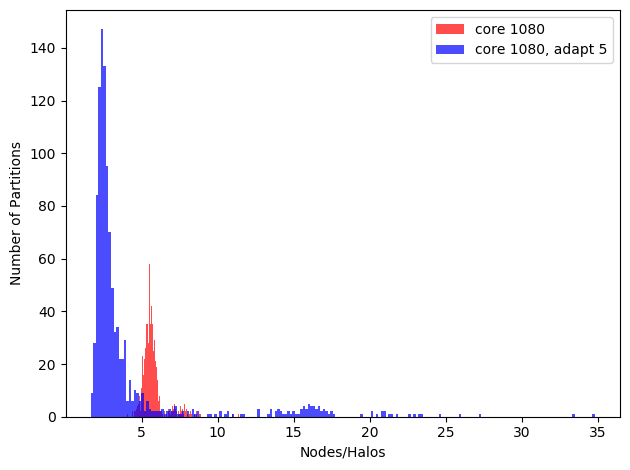

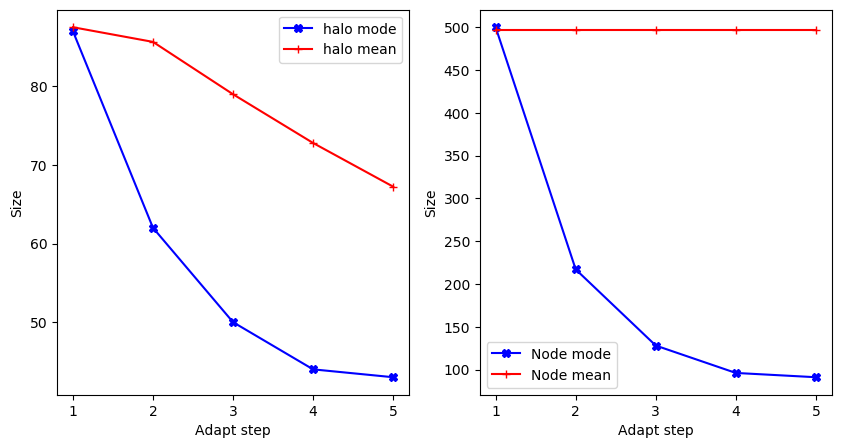

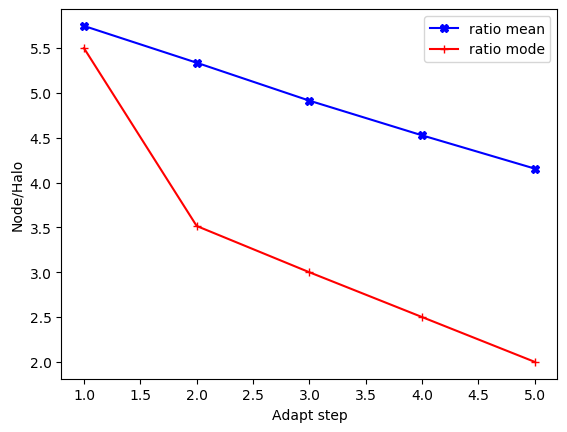

In [7]:
################################################################################
halo_mean_b, halo_mode_b, halos_b = brunner.get_halo_stats(dir_brunner,
                                                     f_brunner_name,
                                                     MAX_ADAPT, CORES[-1])
node_mean_b, node_mode_b, nodes_b = brunner.get_partition_stats(dir_brunner,
                                                          f_brunner_name,
                                                          MAX_ADAPT, CORES[-1])

# Plot histogram distribution o nodes/halos ratio
fig1, ax1 = plt.subplots()
ax1.hist(nodes_b[0::MAX_ADAPT]/halos_b[0::MAX_ADAPT], 200,
         label='core 1080', color='red', alpha=0.7)
ax1.hist(nodes_b[4::MAX_ADAPT]/halos_b[4::MAX_ADAPT], 200,
         label='core 1080, adapt 5', color='blue', alpha=0.7)

ax1.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
ax1.legend()
fig1.tight_layout()
fig1.show()

# Print statistics for halos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, MAX_ADAPT+1), halo_mode_b,
         label='halo mode', color='blue', marker='X')
ax1.plot(range(1, MAX_ADAPT+1), halo_mean_b,
         label='halo mean', color='red', marker='+')
ax1.set(xlabel='Adapt step', ylabel='Size')
ax1.legend()

# Print statistics for node partitions
ax2.plot(range(1, MAX_ADAPT+1), node_mode_b,
         label='Node mode', color='blue', marker='X')
ax2.plot(range(1, MAX_ADAPT+1), node_mean_b,
         label='Node mean', color='red', marker='+')
ax2.set(xlabel='Adapt step', ylabel='Size')
ax2.legend()

fig.show()

# Calculate the mode of Node/Halo,  Mean vs adapt
ratio_mean_b, ratio_mode_b, __ = brunner.get_node_to_halo_ratio_stats(
    dir_brunner, f_brunner_name, MAX_ADAPT, CORES[-1])
fig, ax = plt.subplots()
ax.plot(range(1, MAX_ADAPT+1), ratio_mean_b,
        label='ratio mean', color='blue', marker='X')
ax.plot(range(1, MAX_ADAPT+1), ratio_mode_b,
        label='ratio mode', color='red', marker='+')
ax.set(xlabel='Adapt step', ylabel='Node/Halo')
ax.legend()
fig.show()


 # Strong scaling and absolute performance of the Load Balance time

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


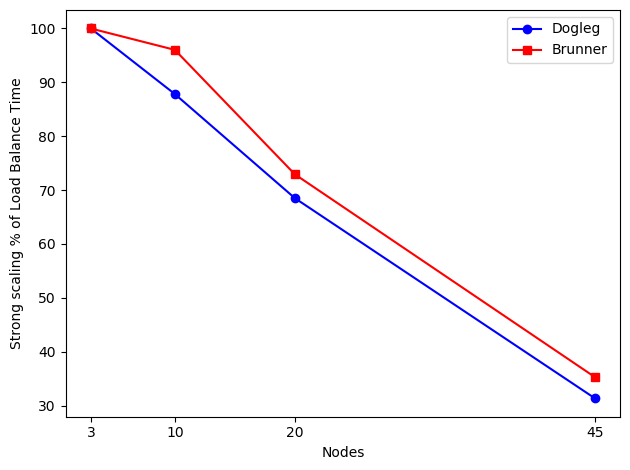

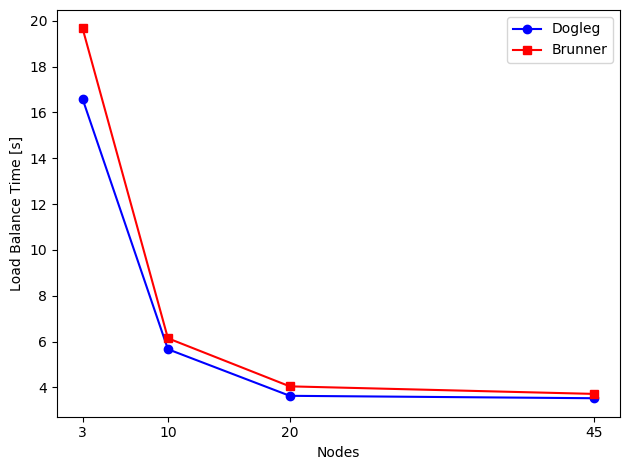

In [8]:
# Get the load balance time for the last adapt step
lb_last_adapt = [lb_t[cpu][-1] for cpu in CORES]
lb_last_adapt_b = [lb_t_b[cpu][-1] for cpu in CORES]    # Brunner problem
# Strong scaled load balance times
ss_lb_last_adapt = [dogleg.strong_scaling(lb_last_adapt[0], min(CORES), time, cpu) for time, cpu in zip(lb_last_adapt, CORES)]
ss_lb_last_adapt_b = [brunner.strong_scaling(lb_last_adapt_b[0], min(CORES), time, cpu) for time, cpu in zip(lb_last_adapt_b, CORES)]
# This plots the strong scaling of the load balance time
fig, ax = plt.subplots()
ax.plot(CORES, ss_lb_last_adapt, color='blue', marker='o', label='Dogleg')
ax.plot(CORES, ss_lb_last_adapt_b, color='red', marker='s', label='Brunner')
ax.set(xlabel='Nodes', ylabel=r'Strong scaling % of Load Balance Time')
ax.set_xticks(CORES)
ax.set_xticklabels(NODES)
ax.legend()
fig.tight_layout()
fig.show()
fig.savefig('./figures/strong_scaling_perf_lb_time_adapt_5.png', dpi=300, pad_inches=0)

# Plots the absolute load balance time
fig, ax = plt.subplots() #figsize=(8,6)
ax.plot(CORES, lb_last_adapt, color='blue', marker='o',label='Dogleg')
ax.plot(CORES, lb_last_adapt_b, color='red', marker='s', label='Brunner')
ax.set(xlabel='Nodes', ylabel='Load Balance Time [s]')
ax.set_xticks(CORES)
ax.set_xticklabels(NODES)
ax.legend()
fig.tight_layout()
fig.show()
fig.savefig('./figures/lb_time_vs_cpu_adapt_5.png', dpi=300, pad_inches=0)


 # Generate frames for the 10 adapt step case (which was run on 10 Nodes)

/home/gn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


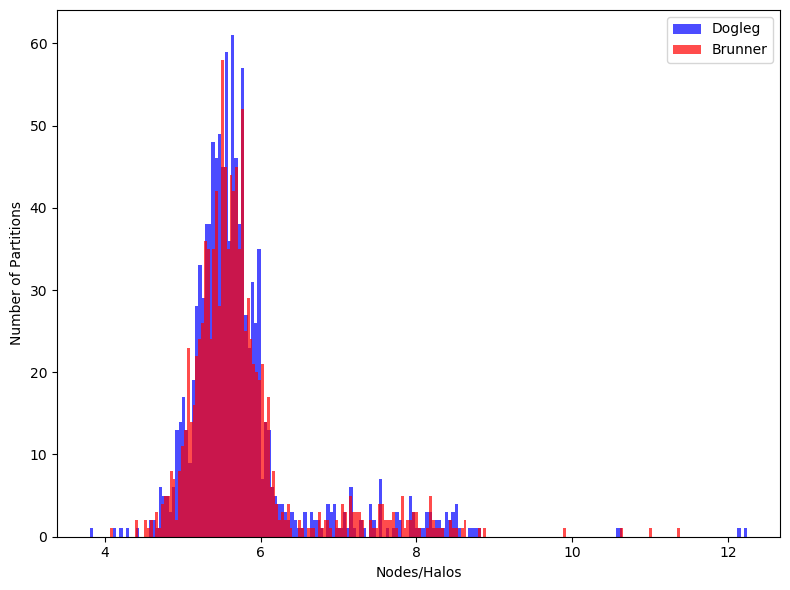

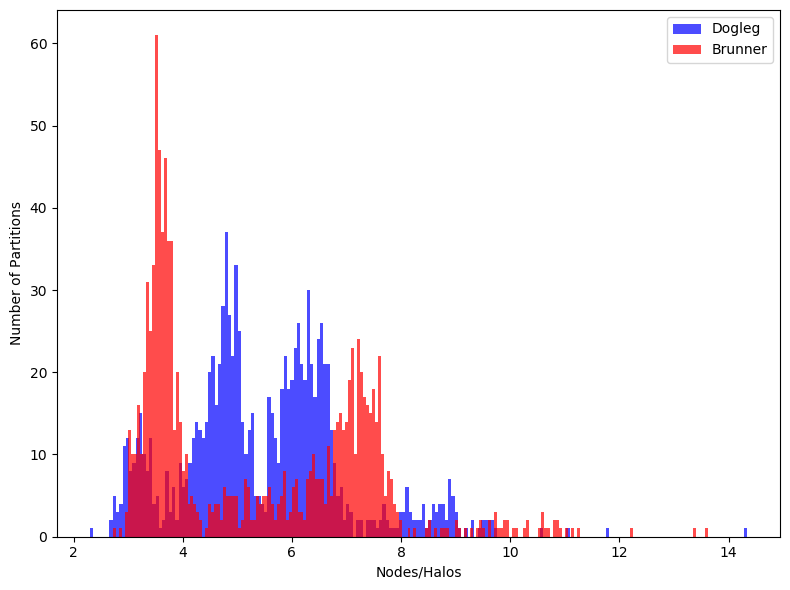

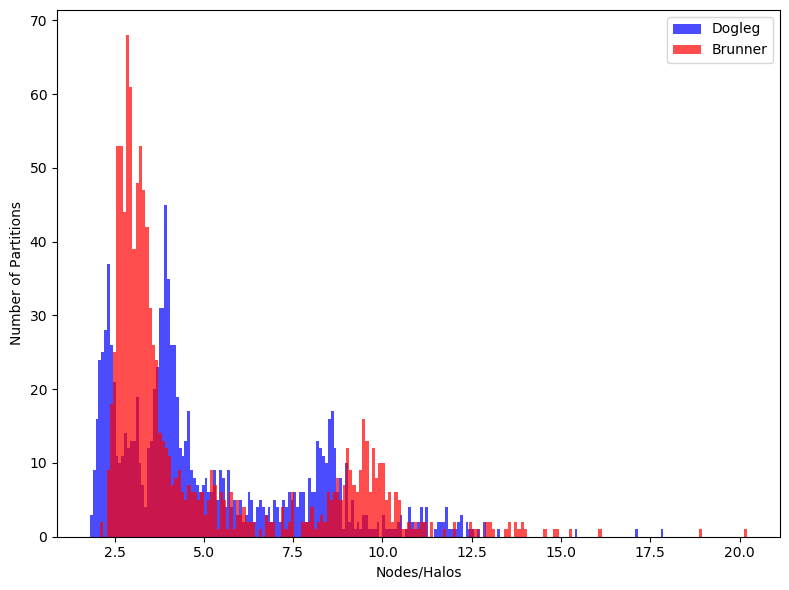

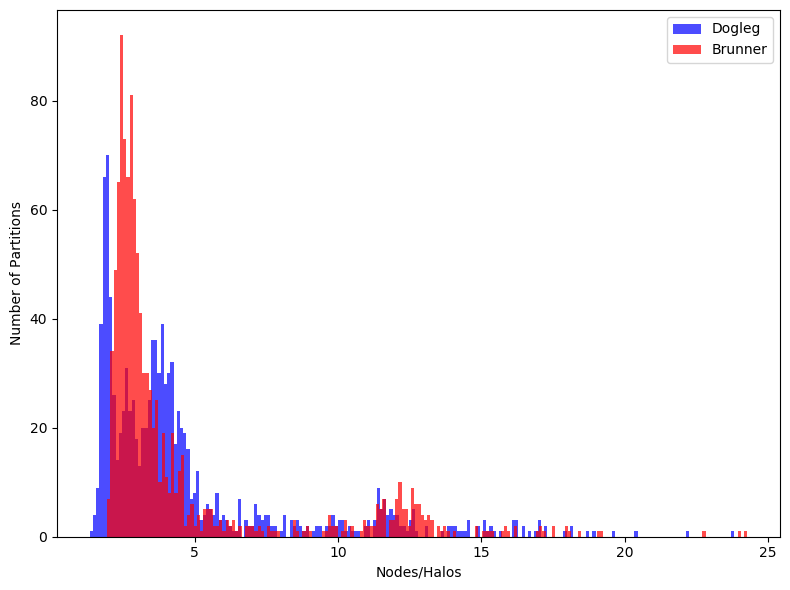

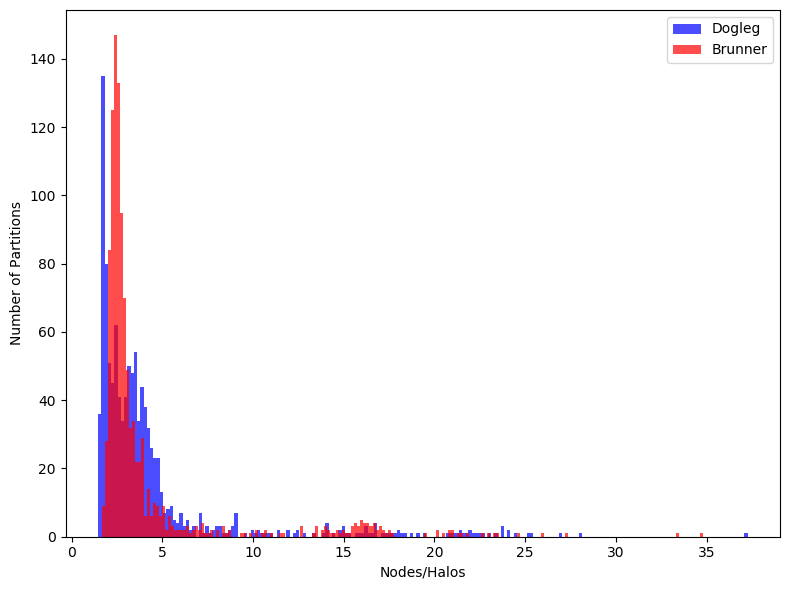

In [9]:
_, ratio_mode_brunner, r_brunner = brunner.get_node_to_halo_ratio_stats(
                                                             dir_brunner, 
                                                             f_brunner_name, 
                                                             MAX_ADAPT, 
                                                             CORES[-1])
_, ratio_mode_dogleg, r_dogleg = dogleg.get_node_to_halo_ratio_stats(dir_dogleg, 
                                                           f_dogleg_name,
                                                           MAX_ADAPT,
                                                          CORES[-1])

# Generate all frames for adapt
for i in range(MAX_ADAPT):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(r_dogleg[i::MAX_ADAPT], bins=200, color='blue', label='Dogleg', alpha=0.7)
    ax.hist(r_brunner[i::MAX_ADAPT], bins=200, color='red', label='Brunner', alpha=0.7)
    ax.set(xlabel='Nodes/Halos', ylabel='Number of Partitions')
    ax.legend()
    fig.tight_layout()
    fig.show()
    fig.savefig(f'node_halo_dist-{i}.png', dpi=300, pad_inches=0)
